In [9]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.18.1-cp312-cp312-macosx_11_0_arm64.whl size=264309 sha256=2d7abad1c970b247ca8a37627e66ad95f120f10f78f0d10c600de66331135581
  Stored in directory: /Users/vithushanesan/Library/Caches/pip/wheels/1a/57/6a/bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Successfully built peewee


In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
Goal: Create a stock portfolio and track historical value at risk 

In [16]:
# Step 1: Pick stocks 
# Step 2: Get daily returns (closing prices)
# Step 3: Create stock portfolio by assigning weights
# Step 4: Create daily return of portfolio 
# Step 5: Sort the return values, and fine VaR at 95% (also 5th percentile of worst returns) 

In [220]:
# Step 1: Pick stocks 

# Ultra short etf, Gold Buillion etf, TSX etf and s&p 500 etfs

# Download data
# ticker =

data = yf.download(ticker, start = "2023-01-01", end = "2025-07-01")

data['Close'].head()


/var/folders/t4/plfsv80s1_32zcrl30pvj2kh0000gn/T/ipykernel_16775/4000479300.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2023-01-01", end = "2025-07-01")
[*********************100%***********************]  4 of 4 completed


Ticker,PLTR,TD.TO,VFV.TO,XIU.TO
Date,,,,
2023-01-03,6.39,77.514030,90.108757,27.486254
2023-01-04,6.58,78.521965,89.564774,27.671164
2023-01-05,6.32,77.234879,89.040207,27.578711
2023-01-06,6.40,77.199120,90.157341,28.022484
2023-01-09,6.50,76.957787,89.768784,28.068712


In [224]:
data2 = data.copy()

In [226]:
# Assigning weights to each security in the portfolio
# weights = {
#     'CGL.TO' : 0.25, 
#     'VFV.TO' : 0.25,
#     'XIU.TO' : 0.25, 
#     'ZST.TO' : 0.25 
# }

weights = {
    'PLTR' : 0.25, 
    'TD.TO' : 0.25,
    'XIU.TO' : 0.25, 
    'VFV.TO' : 0.25 
}

closing_prices = data2['Close'][list(weights.keys())]


# Calculating Daily return (pct change calculates % changes from previous day)
daily_returns = closing_prices.pct_change()

# portfolio daily return (weighted sum), dot does matrix muliplication for each day, mulitplies each return by its weight and sums it
portfolio_returns = daily_returns.dot(list(weights.values()))

portfolio_returns.name = 'Portfolio Daily return'


/var/folders/t4/plfsv80s1_32zcrl30pvj2kh0000gn/T/ipykernel_16775/1164288229.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = closing_prices.pct_change()


In [228]:
# converting to dataframe

portfolio_returns_df = portfolio_returns.to_frame(name='Daily Return')
portfolio_returns_df.head()

,Daily Return
Date,
2023-01-03,NaN
2023-01-04,0.010857
2023-01-05,-0.016276
2023-01-06,0.010208
2023-01-09,0.002460


In [230]:
# First, create a cumulative return series 

portfolio_returns_df['Cumulative Return'] = (1 + portfolio_returns_df['Daily Return']).cumprod()

# Secondly, apply initital investment to see how portfolio grows over time 
initial_investment = 10000

portfolio_returns_df['Portfolio Value'] = portfolio_returns_df['Cumulative Return']*initial_investment

In [232]:
portfolio_returns_df = portfolio_returns_df.reset_index()
portfolio_returns_df

,Date,Daily Return,Cumulative Return,Portfolio Value
0,2023-01-03,NaN,NaN,NaN
1,2023-01-04,0.010857,1.010857,10108.569032
2,2023-01-05,-0.016276,0.994404,9944.044406
3,2023-01-06,0.010208,1.004556,10045.555149
4,2023-01-09,0.002460,1.007026,10070.264185
...,...,...,...,...
633,2025-06-24,0.012045,3.193152,31931.522003
634,2025-06-25,-0.001707,3.187702,31877.024710
635,2025-06-26,0.006073,3.207062,32070.623373
636,2025-06-27,-0.021433,3.138324,31383.242082


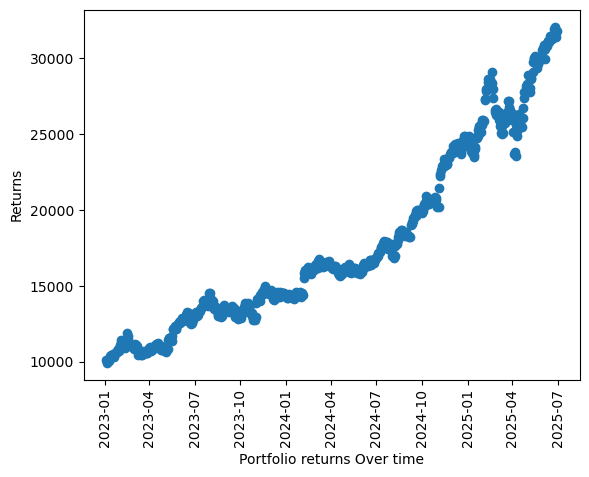

In [234]:
plt.scatter(portfolio_returns_df["Date"], portfolio_returns_df['Portfolio Value'])
plt.xlabel('Portfolio returns Over time')
plt.xticks(rotation=90)
plt.ylabel('Returns')
plt.show()


# Now that I've seen how the stock portfolio has performed in the past, now I want to use predictive modelling to see how the portfolio may do in the future

In [240]:
data2.head()

Price      Close                                    High             \
Ticker      PLTR      TD.TO     VFV.TO     XIU.TO   PLTR      TD.TO   
Date                                                                  
2023-01-03  6.39  77.514030  90.108757  27.486254  6.640  78.681117   
2023-01-04  6.58  78.521965  89.564774  27.671164  6.675  79.105512   
2023-01-05  6.32  77.234879  89.040207  27.578711  6.490  78.459406   
2023-01-06  6.40  77.199120  90.157341  28.022484  6.450  77.699656   
2023-01-09  6.50  76.957787  89.768784  28.068712  6.670  77.628151   

Price                               Low                                   \
Ticker         VFV.TO     XIU.TO   PLTR      TD.TO     VFV.TO     XIU.TO   
Date                                                                       
2023-01-03  90.866462  27.763614  6.275  77.478663  89.292762  27.384557   
2023-01-04  90.021341  27.763617  6.370  77.841167  88.884784  27.449277   
2023-01-05  89.487058  27.634182  6.250  77.136558  88.739062  27.412295   
2023-01-06  90.390487  28.031729  6.090  77.029292  88.981926  27.643427   
2023-01-09  90.953908  28.253617  6.400  76.698578  89.710493  28.040976   

Price       Open                                       Volume              \
Ticker      PLTR      TD.TO     VFV.TO     XIU.TO        PLTR       TD.TO   
Date                                                                        
2023-01-03  6.58  78.407031  90.866462  27.578707  29969900.0  20465200.0   
2023-01-04  6.48  77.885371  89.555065  27.560219  31660500.0  19876200.0   
2023-01-05  6.45  78.164444  89.302487  27.597202  34186000.0   4881400.0   
2023-01-06  6.40  77.538768  89.487067  27.726635  30596400.0   6166400.0   
2023-01-09  6.49  77.494076  90.487631  28.170409  31028900.0   4390400.0   

Price                            
Ticker        VFV.TO     XIU.TO  
Date                             
2023-01-03  142800.0  1748300.0  
2023-01-04  170700.0  2964300.0  
2023-01-05  174800.0  1870900.0  
2023-01-06  209400.0  2793000.0  
2023-01-09  141200.0  2234200.0

In [256]:
portfolio_returns_df['Stock Volume'] = data2[['Close']]

ValueError: Cannot set a DataFrame with multiple columns to the single column Stock Volume

In [242]:
data2[["Close"]]

Price            Close                                   
Ticker            PLTR       TD.TO      VFV.TO     XIU.TO
Date                                                     
2023-01-03    6.390000   77.514030   90.108757  27.486254
2023-01-04    6.580000   78.521965   89.564774  27.671164
2023-01-05    6.320000   77.234879   89.040207  27.578711
2023-01-06    6.400000   77.199120   90.157341  28.022484
2023-01-09    6.500000   76.957787   89.768784  28.068712
...                ...         ...         ...        ...
2025-06-24  143.229996   98.580002  148.314972  40.240002
2025-06-25  142.899994   98.839996  148.285034  39.959999
2025-06-26  144.250000   99.459999  148.554382  40.230000
2025-06-27  130.740005   99.449997  149.931000  40.180000
2025-06-30  136.320007  100.160004  149.869995  40.410000

[638 rows x 4 columns]

In [252]:
data2[['Close','Volume']]

Price            Close                                          Volume  \
Ticker            PLTR       TD.TO      VFV.TO     XIU.TO         PLTR   
Date                                                                     
2023-01-03    6.390000   77.514030   90.108757  27.486254   29969900.0   
2023-01-04    6.580000   78.521965   89.564774  27.671164   31660500.0   
2023-01-05    6.320000   77.234879   89.040207  27.578711   34186000.0   
2023-01-06    6.400000   77.199120   90.157341  28.022484   30596400.0   
2023-01-09    6.500000   76.957787   89.768784  28.068712   31028900.0   
...                ...         ...         ...        ...          ...   
2025-06-24  143.229996   98.580002  148.314972  40.240002   58574200.0   
2025-06-25  142.899994   98.839996  148.285034  39.959999   61435300.0   
2025-06-26  144.250000   99.459999  148.554382  40.230000   69440500.0   
2025-06-27  130.740005   99.449997  149.931000  40.180000  202598600.0   
2025-06-30  136.320007  100.160004  149.869995  40.410000   97305600.0   

Price                                        
Ticker           TD.TO    VFV.TO     XIU.TO  
Date                                         
2023-01-03  20465200.0  142800.0  1748300.0  
2023-01-04  19876200.0  170700.0  2964300.0  
2023-01-05   4881400.0  174800.0  1870900.0  
2023-01-06   6166400.0  209400.0  2793000.0  
2023-01-09   4390400.0  141200.0  2234200.0  
...                ...       ...        ...  
2025-06-24   7197700.0  226700.0  2097000.0  
2025-06-25   3939800.0  187100.0  1766100.0  
2025-06-26   4830900.0  190200.0  4410700.0  
2025-06-27   8128600.0  272400.0  3753000.0  
2025-06-30   7843400.0  298600.0  3257700.0  

[638 rows x 8 columns]